
# Preprocessing for MIT data (multiple classification) with MinMax Scaler and Oversamling
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.


Processing **steps** for MIT dataset:   
    resample: Oversampling  
    rescaling: MinMaxScaler  


**Input** : Cleaned data with multiple classes target variable.   
mitbih_test.csv   
mitbih_train.csv

**Output** : Sampled and Scaled data with multiple classes target variable:   
mitbih_multiclass_train_shift_minmax_oversampling.csv  
mitbih_multiclass_test_shift_minmax_oversampling.csv



In [38]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import pywt
cA, cD = pywt.dwt([1, 2, 3, 4], 'db1') # Discrete Wavelet Transform
from scipy.fft import fft, ifft
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Detect environment and set paths
data_path = ''
data_output_path = ''
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
else:
    print("Running on local environment")
    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [39]:
# File paths
RawFiles = dict({
    'test': data_path +  'mitbih_test.csv', 
    'train': data_path +  'mitbih_train.csv', 
})

OutputFiles = dict({
    'test': data_output_path + 'mitbih_test_multiclass_shift_minmax_oversampling.csv',
    'train': data_output_path + 'mitbih_train_multiclass_shift_minmax_oversampling.csv',
})


## Load data

In [40]:
train = pd.read_csv(RawFiles['train'], header=None)
test = pd.read_csv(RawFiles['test'], header=None)

In [41]:
def preprocess_dataframe(df):
    """Preprocess the DataFrame by adding columns and mapping targets."""
    # Add feature columns
    num_columns = df.shape[1]
    feature_columns = [f'c_{i}' for i in range(num_columns - 1)]
    df.columns = feature_columns + ['target']
    
    # Ensure target column is integer
    df['target'] = pd.to_numeric(df['target'], errors='coerce')
    df.dropna(subset=['target'], inplace=True)
    df['target'] = df['target'].astype(int)
    return df

# Preprocess train and test datasets
train = preprocess_dataframe(train)
test = preprocess_dataframe(test)


# Separate signals and target labels

In [42]:
# Train dataset
train_signals = train.iloc[:, :-1].values  # All columns except the last
train_labels = train.iloc[:, -1].values   # The last column (target labels)

# Test dataset
test_signals = test.iloc[:, :-1].values
test_labels = test.iloc[:, -1].values

ECG signal consists of P, QRS complex, and T waves.  

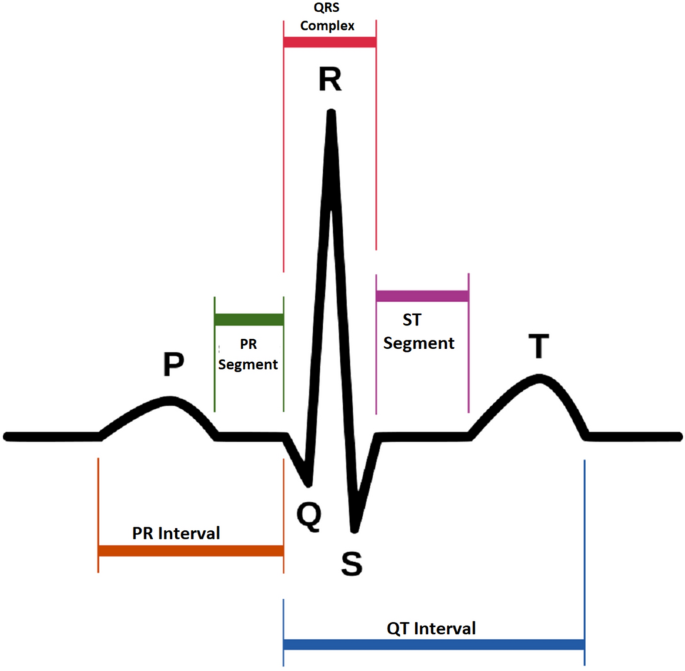

(1) To remove noise and artifacts, the conventional wavelet-transform-based filtering method is used by the authors (https://pywavelets.readthedocs.io/en/latest/) (https://www.youtube.com/watch?v=kuuUaqAjeoA), 

(2) for the detection of P, QRS complex, and T waveforms TERMA and FrFT are fused together to improve the detection performance, and 

(3) machine learning algorithms are applied to classify ECG signals to determine the CVD if any. 

- The wavelet-transform-based filtering method is a powerful tool for noise reduction and signal enhancement, particularly useful for signals with non-stationary or transient behavior.
- The Fractional Fourier Transform (FrFT) is a generalized version of the Fourier Transform that analyzes signals in intermediate domains between time and frequency, controlled by a fractional order parameter. It provides flexibility to focus on specific features of a signal, making it ideal for complex or non-stationary signals with time-varying frequency components.
- TERMA and moving averages help focus on key events by smoothing and filtering out noise, making them effective for identifying patterns in both economic and physiological contexts. For ECG signals: Moving averages smooth the cyclic waveform of heartbeats, aiding in recognizing events like the P wave or QRS complex. Time-frequency analysis accommodates the variations in these signals, offering a dynamic way to understand and detect abnormalities or shifts over time.

We want to reproduce the preprocessing of the paper to give Feature Importance and SHAP a meaningful interpretation.

### Wavelet-based signal denoising specifically for ECG signals

In [43]:
def wavelet_denoise(ecg_signal, wavelet='db4', level=9, threshold_method='soft', threshold_factor=0.5):
    """
    Denoise the ECG signal using wavelet transform with thresholding.

    Parameters:
    - ecg_signal: The 1D signal to denoise.
    - wavelet: The type of wavelet to use (default: 'db4').
    - level: The number of decomposition levels (default: 9).
    - threshold_method: 'soft' or 'hard' thresholding (default: 'soft').
    - threshold_factor: Scaling factor for thresholding (default: 0.5).

    Returns:
    - Denoised signal.
    """
    # Decompose the signal
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level) # Wavelet decomposition, level 9 is good for ECG signals
    
    # Calculate the universal threshold (dependent on signal length)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Robust estimate of noise standard deviation
    threshold = threshold_factor * sigma * np.sqrt(2 * np.log(len(ecg_signal)))

    # Apply thresholding to detail coefficients
    denoised_coeffs = [coeffs[0]]  # Keep the approximation coefficients
    for c in coeffs[1:]:
        if threshold_method == 'soft':
            denoised_coeffs.append(np.sign(c) * np.maximum(np.abs(c) - threshold, 0))
        elif threshold_method == 'hard':
            denoised_coeffs.append(c * (np.abs(c) > threshold))
        else:
            raise ValueError("Invalid threshold_method. Choose 'soft' or 'hard'.")

    # Reconstruct the signal from modified coefficients
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    
    return denoised_signal  


### TERMA Framework Function for ECG Signals

In [44]:
def terma_ecg_detection(ecg_signal, window_size=50, threshold_factor=0.5):
    """
    Detect peaks (P, QRS, T waves) in ECG signals using TERMA framework.

    Parameters:
    - ecg_signal: The 1D signal to process.
    - window_size: The size of the moving average window (default: 50 samples).
    - threshold_factor: Factor for adaptive peak detection threshold (default: 0.5).

    Returns:
    - Detected peaks: Indices of the detected peaks in the signal.
    """
    # Compute Moving Average
    moving_avg = np.convolve(ecg_signal, np.ones(window_size) / window_size, mode='same')

    # Adaptive Thresholding
    signal_std = np.std(ecg_signal)
    adaptive_threshold = threshold_factor * signal_std
    potential_peaks = np.where(ecg_signal > moving_avg + adaptive_threshold)[0]

    # Refine Peaks
    refined_peaks = []
    for i in range(1, len(potential_peaks) - 1):
        if ecg_signal[potential_peaks[i]] > ecg_signal[potential_peaks[i - 1]] and \
           ecg_signal[potential_peaks[i]] > ecg_signal[potential_peaks[i + 1]]:
            refined_peaks.append(potential_peaks[i])

    return np.array(refined_peaks)


### FrFT 


In [45]:
def frft(x, alpha):
    """
    Fractional Fourier Transform of a signal.
    :param x: Input signal (1D array).
    :param alpha: Fractional order (float).
    :return: Fractionally transformed signal.
    """
    N = len(x)
    theta = np.pi * alpha / 2
    t = np.arange(N)

    # Chirp Multiplication
    chirp = np.exp(-1j * np.tan(theta / 2) * (t ** 2))
    x_tilted = chirp * x

    # FFT
    X = np.fft.fft(x_tilted)

    # Inverse Chirp Multiplication
    chirp_inv = np.exp(-1j * np.tan(theta / 2) * (t ** 2))
    x_frft = chirp_inv * np.fft.ifft(X)

    return x_frft

### Align and Pad signals for ML and DL algorithms

In [46]:
def align_and_pad_signals(signals, pad_value=0):
    """
    Align and pad a list of ECG signals to the same length.
    
    Parameters:
    - signals: List of 1D numpy arrays representing ECG signals.
    - pad_value: Value to use for padding (default: 0).
    
    Returns:
    - Aligned and padded signals as a 2D numpy array.
    """
    # Determine the maximum length
    max_length = max(len(signal) for signal in signals)
    
    # Pad each signal to the maximum length
    padded_signals = np.array([np.pad(signal, (0, max_length - len(signal)), constant_values=pad_value) for signal in signals])
    
    return padded_signals


#### Denoise the Signals

In [47]:
# Denoise train and test signals
train_denoised = [wavelet_denoise(signal) for signal in train_signals]
test_denoised = [wavelet_denoise(signal) for signal in test_signals]


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


#### Detect R-Peaks with TERMA

In [48]:
train_r_peaks = [terma_ecg_detection(signal) for signal in train_denoised]
test_r_peaks = [terma_ecg_detection(signal) for signal in test_denoised]


#### Align and pad signals

In [49]:
train_aligned = align_and_pad_signals(train_denoised)
test_aligned = align_and_pad_signals(test_denoised)

#### Apply Fractional Fourier Transform

In [50]:
train_frft = [frft(signal, alpha=0.5) for signal in train_aligned]
test_frft = [frft(signal, alpha=0.5) for signal in test_aligned]


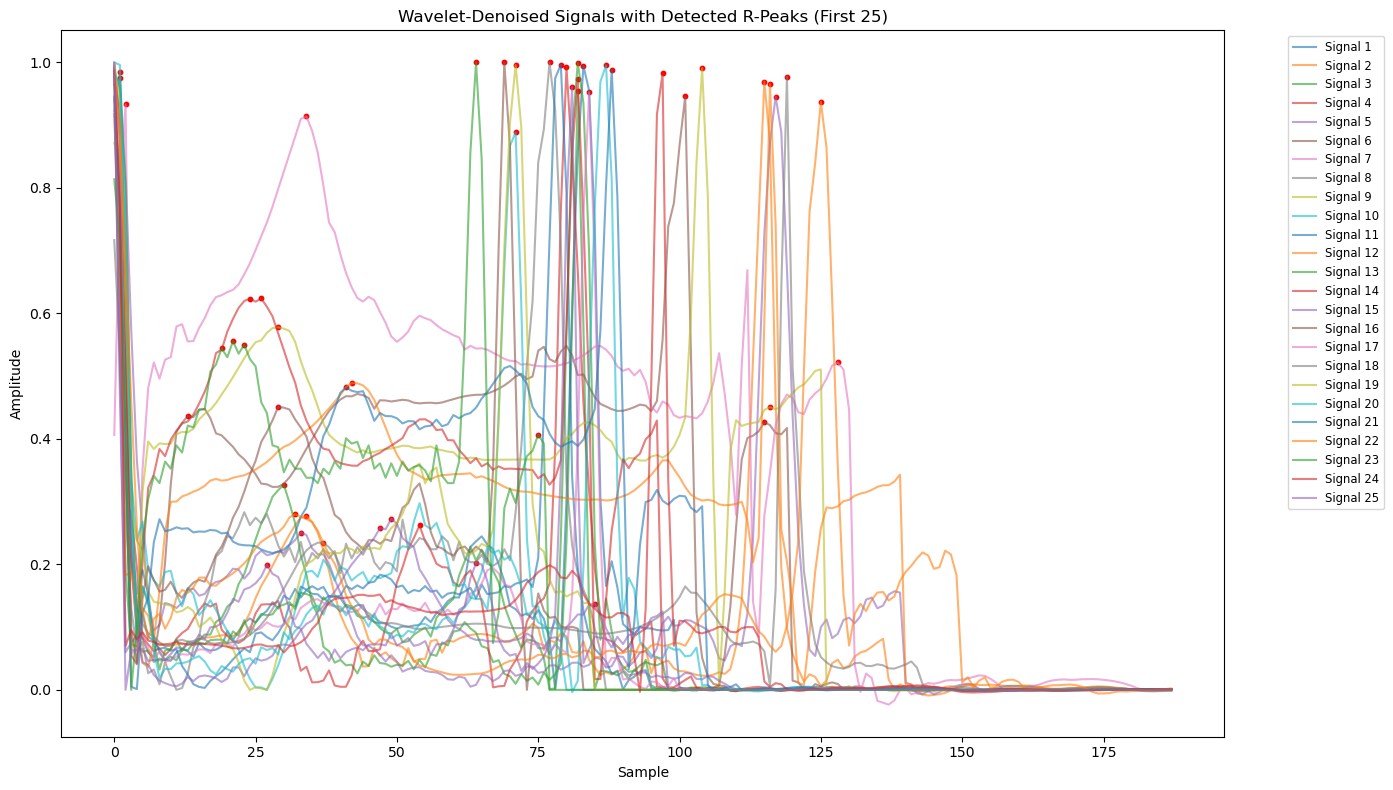

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


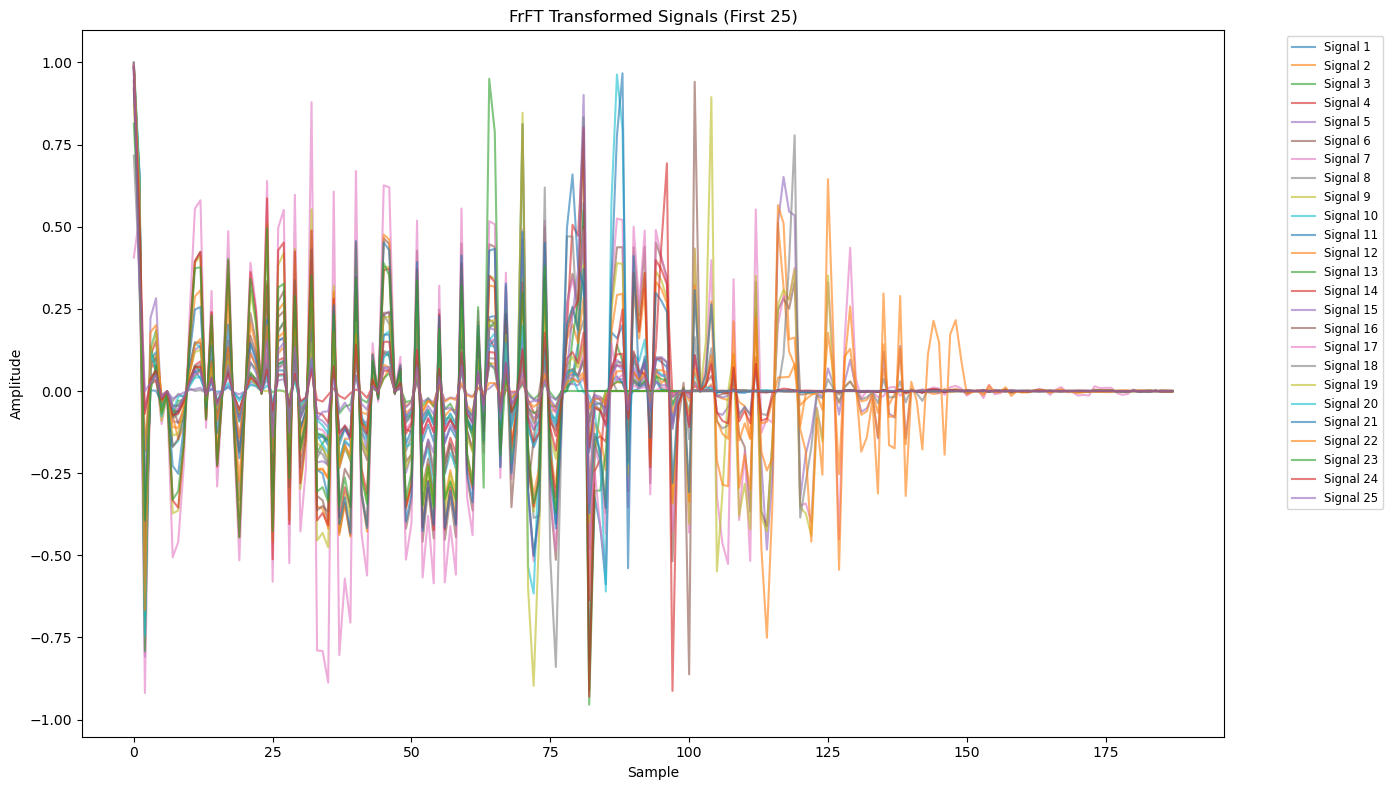

In [51]:
# Plot the first 25 wavelet-denoised signals in one graph with their detected R-peaks
plt.figure(figsize=(14, 8))

for signal_index in range(25):  # Loop through the first 25 signals
    plt.plot(train_denoised[signal_index], label=f"Signal {signal_index+1}", alpha=0.6)
    plt.scatter(train_r_peaks[signal_index], 
                [train_denoised[signal_index][i] for i in train_r_peaks[signal_index]], 
                color='red', s=10)  # Detected R-peaks

plt.title("Wavelet-Denoised Signals with Detected R-Peaks (First 25)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


# Plot a subset of FrFT transformed signals
plt.figure(figsize=(14, 8))
for i, signal in enumerate(train_frft[:25]):  # Adjust subset size as needed
    plt.plot(signal, label=f'Signal {i+1}', alpha=0.6)
plt.title("FrFT Transformed Signals (First 25)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()



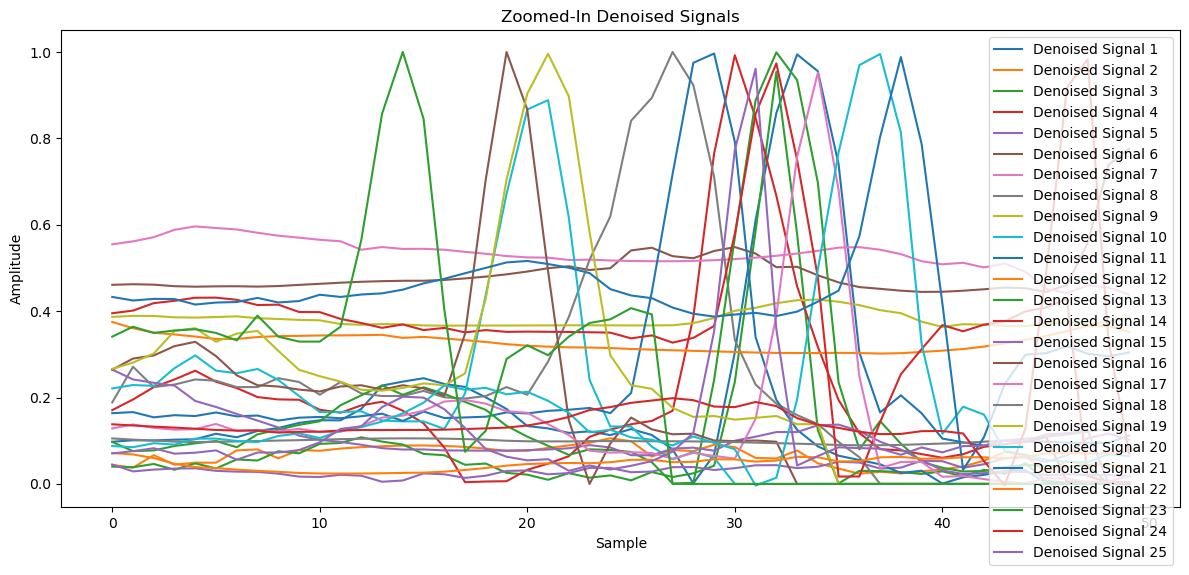

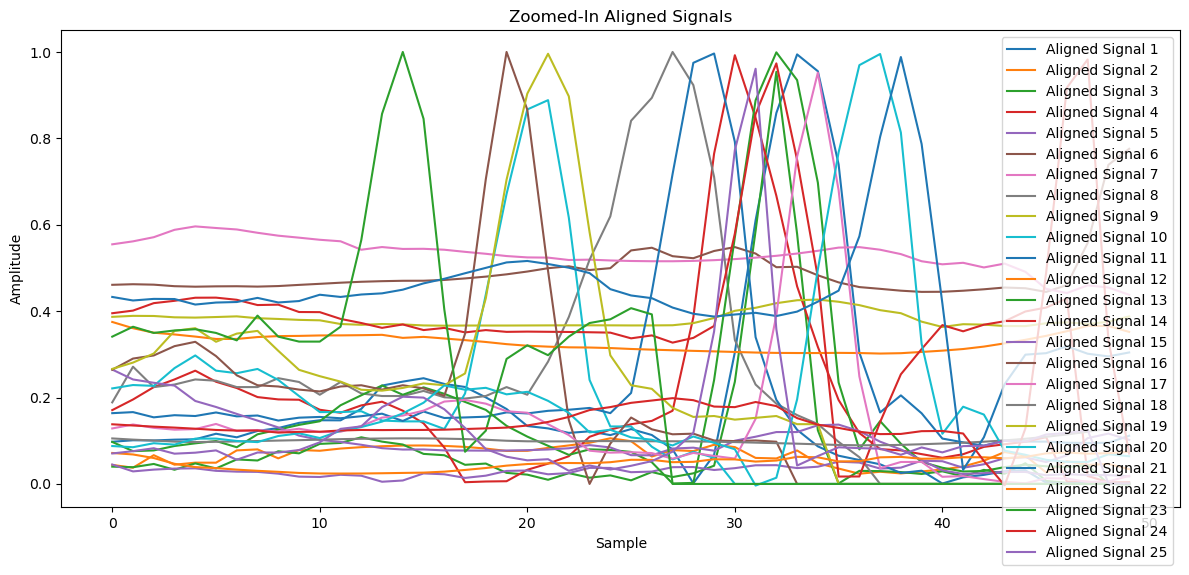

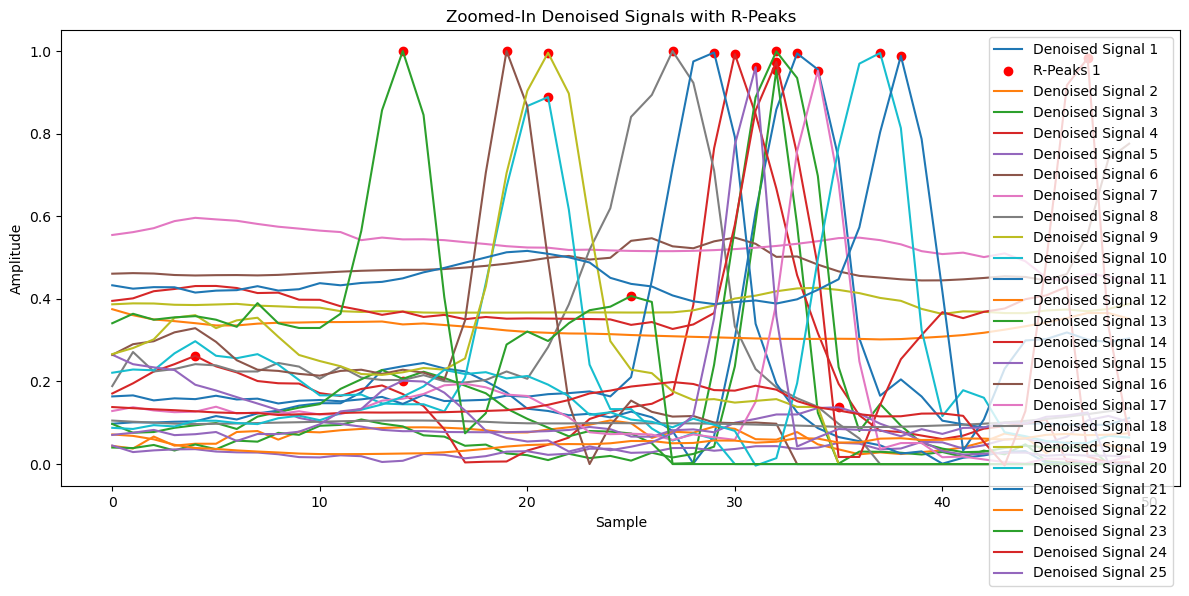

In [52]:
import matplotlib.pyplot as plt

def plot_zoomed_signals(train_denoised, train_aligned, train_r_peaks, zoom_range=(50, 100)):
    """
    Plot zoomed-in versions of the denoised, aligned, and R-peak annotated signals.

    Parameters:
    - train_denoised: List of denoised signals.
    - train_aligned: List of aligned signals.
    - train_r_peaks: List of R-peak indices for the signals.
    - zoom_range: Tuple specifying the range to zoom in on (start, end).
    """
    start, end = zoom_range

    # Plot denoised signals (zoomed)
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(train_denoised[:25]):  # Plot first 3 signals
        plt.plot(signal[start:end], label=f"Denoised Signal {i+1}")
    plt.title("Zoomed-In Denoised Signals")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot aligned signals (zoomed)
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(train_aligned[:25]):  # Plot first 3 signals
        plt.plot(signal[start:end], label=f"Aligned Signal {i+1}")
    plt.title("Zoomed-In Aligned Signals")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot denoised signals with R-peaks (zoomed)
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(train_denoised[:25]):  # Plot first 3 signals
        plt.plot(signal[start:end], label=f"Denoised Signal {i+1}")
        # Overlay R-peaks
        peaks_in_range = [p for p in train_r_peaks[i] if start <= p < end]
        plt.scatter(
            [p - start for p in peaks_in_range],  # Adjust for zoom range
            [signal[p] for p in peaks_in_range],
            color="red", label=f"R-Peaks {i+1}" if i == 0 else None
        )
    plt.title("Zoomed-In Denoised Signals with R-Peaks")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_zoomed_signals(train_denoised, train_aligned, train_r_peaks, zoom_range=(50, 100))


In [53]:
zoom_range = (0, 187) 
def extract_zoomed_data_without_index(train_denoised, train_aligned, train_r_peaks, zoom_range=(0, 187)):
    """
    Extract zoomed-in signal data and R-peak information, and save it to a DataFrame.

    Parameters:
    - train_denoised: List of denoised signals.
    - train_aligned: List of aligned signals.
    - train_r_peaks: List of R-peak indices for the signals.
    - zoom_range: Tuple specifying the range to zoom in on (start, end).

    Returns:
    - DataFrame containing zoomed-in signal data and R-peak information.
    """
    start, end = zoom_range
    data = []

    for i in range(len(train_denoised)):
        # Extract zoomed-in signal data
        denoised_zoom = train_denoised[i][start:end]
        aligned_zoom = train_aligned[i][start:end]

        # Extract R-peak information within the zoom range
        peaks_in_range = [p for p in train_r_peaks[i] if start <= p < end]
        peaks_amplitude = [train_denoised[i][p] for p in peaks_in_range]

        # Flatten the data for easy tabular storage
        data.append({
            "Denoised_Zoom": ','.join(map(str, denoised_zoom)),
            "Aligned_Zoom": ','.join(map(str, aligned_zoom)),
            "R_Peaks_Indices": ','.join(map(str, peaks_in_range)),
            "R_Peaks_Amplitudes": ','.join(map(str, peaks_amplitude))
        })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df

# Extract zoomed-in data and save to DataFrame
zoomed_train_df = extract_zoomed_data_without_index(train_denoised, train_aligned, train_r_peaks, zoom_range=zoom_range)


# Display the DataFrame
zoomed_train_df.head()



,Denoised_Zoom,Aligned_Zoom,R_Peaks_Indices,R_Peaks_Amplitudes
0,"0.9754038901432308,0.9238082688447059,0.677743...","0.9754038901432308,0.9238082688447059,0.677743...",83,0.9943313925495175
1,"0.940711061675255,0.823913911718574,0.45873201...","0.940711061675255,0.823913911718574,0.45873201...","34,115","0.2770696021855816,0.969566705555985"
2,"0.9952721365324131,0.6496916689232597,0.186397...","0.9952721365324131,0.6496916689232597,0.186397...","30,82","0.3268875448977414,0.9538380317048292"
3,"0.9180870799711052,0.664362356756491,0.5371252...","0.9180870799711052,0.664362356756491,0.5371252...","54,80","0.2621878667844124,0.9924693807901385"
4,"0.9650753234104763,0.9747274870610537,0.820625...","0.9650753234104763,0.9747274870610537,0.820625...","1,33,117","0.9747274870610537,0.2505073463450241,0.945556..."


In [54]:
# Function for extracting zoomed-in data for test signals
zoomed_test_df = extract_zoomed_data_without_index(test_denoised, test_aligned, test_r_peaks, zoom_range=(0, 187))


### Convert for both train and test DataFrames

In [55]:
# Convert columns with string representations of arrays to numerical arrays
def parse_string_columns_to_arrays(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.array(list(map(float, x.split(',')))) if isinstance(x, str) else x)
    return df

# Apply the conversion to the train and test DataFrames
columns_to_convert = ["Denoised_Zoom", "Aligned_Zoom"]
zoomed_train_df = parse_string_columns_to_arrays(zoomed_train_df, columns_to_convert)
zoomed_test_df = parse_string_columns_to_arrays(zoomed_test_df, columns_to_convert)



### Add labels to the feature DataFrames

In [56]:
# Add the target labels to the DataFrame
zoomed_train_df['target'] = train_labels
zoomed_test_df['target'] = test_labels

## Oversample the Training Data

In [57]:
# Initialize the oversampler
oversampler = RandomOverSampler(random_state=42)

# Prepare data for oversampling
X_train = np.stack(zoomed_train_df["Denoised_Zoom"].values)  # Ensure 2D array
y_train = zoomed_train_df['target'].values

# Apply oversampling
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)



## Scaling of the oversampled training data and the original test data.

In [58]:
# Ensure consistent feature size by truncating or padding
def adjust_feature_length(arrays, target_length):
    return np.array([np.pad(arr[:target_length], (0, max(0, target_length - len(arr))), constant_values=0) for arr in arrays])

# Adjust both train and test datasets
X_train = adjust_feature_length(zoomed_train_df["Denoised_Zoom"].values, target_length=187)
X_test = adjust_feature_length(zoomed_test_df["Denoised_Zoom"].values, target_length=187)


In [59]:
# Initialize the scaler
scaler = MinMaxScaler()

# Scale training data
X_train_scaled = scaler.fit_transform(X_train_oversampled)

# Scale testing data
X_test_scaled = scaler.transform(X_test)



## Combine Scaled Features with Labels

In [60]:
# Combine training features and targets
train_combined = pd.DataFrame(X_train_scaled, columns=[f'c_{i}' for i in range(X_train_scaled.shape[1])])
train_combined['target'] = y_train_oversampled

# Combine testing features and targets
test_combined = pd.DataFrame(X_test_scaled, columns=[f'c_{i}' for i in range(X_test_scaled.shape[1])])
test_combined['target'] = zoomed_test_df['target'].values



In [61]:
# Save the processed datasets to CSV files
train_combined.to_csv(OutputFiles['train'], index=False)
test_combined.to_csv(OutputFiles['test'], index=False)

In [62]:
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-09 12:18:14.191118


# **ECG Signal Preprocessing Documentation**

This documentation outlines the functionality and processes implemented in the code for preprocessing ECG signals, detecting peaks, aligning signals, and preparing the dataset for machine learning.

---

## **Overview**

The code processes ECG signals using various signal processing techniques, prepares the data for classification tasks, and ensures data integrity through preprocessing, alignment, scaling, and oversampling. This pipeline is designed for efficient and accurate heartbeat classification.

---

## **Pipeline Workflow**

### **1. Environment Setup**
The code detects the runtime environment and sets file paths accordingly:
- **Google Colab**: Mounts Google Drive and sets paths for raw and processed data.
- **Local Environment**: Uses relative paths to access raw and processed datasets.

---

### **2. File Paths**
File paths are defined for raw and processed data:
- **RawFiles**: Locations of raw training and test datasets (`mitbih_train.csv`, `mitbih_test.csv`).
- **OutputFiles**: Locations for saving processed datasets after preprocessing.

---

### **3. Preprocessing Functions**

#### **3.1 Preprocess DataFrames (`preprocess_dataframe`)**
Steps:
1. Adds feature column names (e.g., `c_1`, `c_2`, etc.) and a target column.
2. Ensures the `target` column is numeric and removes invalid rows.
3. Converts the target column to integer format for classification.

---

### **4. Signal Processing**

#### **4.1 Wavelet Denoising (`wavelet_denoise`)**
- Removes high-frequency noise from ECG signals using the discrete wavelet transform (`db4`).
- Applies thresholding to wavelet coefficients for noise reduction.

#### **4.2 Fractional Fourier Transform (`frft`)**
- Computes the fractional Fourier transform, which emphasizes signal peaks for better feature extraction.

#### **4.3 Peak Detection (`terma_ecg_detection`)**
- Identifies peaks in ECG signals, including R-peaks, using a moving average and adaptive thresholding.

#### **4.4 Alignment and Padding (`align_and_pad_signals`)**
- Aligns ECG signals by centering them around the first R-peak.
- Pads signals to a fixed length (default: 187 samples) for uniformity.

---

### **5. Feature Extraction**

#### **5.1 Zoomed Data Extraction (`extract_zoomed_data`)**
- Extracts zoomed-in signal segments and corresponding R-peak information.
- Saves zoomed-in signals (denoised and aligned) to a DataFrame for easy processing.

#### **5.2 Parsing String Data**
- Converts columns with string representations of arrays (e.g., `Denoised_Zoom`, `Aligned_Zoom`) into numerical arrays.

---

### **6. Data Preparation**

#### **6.1 Oversampling**
- Balances the class distribution in the training data using **Random Oversampler**.

#### **6.2 Feature Adjustment**
- Truncates or pads arrays to ensure all samples have a consistent feature size (187 features).

#### **6.3 Scaling**
- Scales features to a range of [0, 1] using **MinMaxScaler** to normalize values.

---

### **7. Combining Features and Targets**
- Combines scaled features and their corresponding targets into DataFrames (`train_combined`, `test_combined`).
- Saves processed datasets to CSV files.

---

## **Pipeline Implementation**

### **Functions**
1. **Preprocessing:**
   - `preprocess_dataframe`
   - `wavelet_denoise`
2. **Signal Processing:**
   - `frft`
   - `terma_ecg_detection`
   - `align_and_pad_signals`
3. **Feature Extraction:**
   - `extract_zoomed_data_without_index`
4. **Data Preparation:**
   - Oversampling using `RandomOverSampler`
   - Scaling using `MinMaxScaler`
5. **File Export:**
   - Save processed datasets to CSV files.

---

## **Key Features**

1. **Noise Reduction:**
   - Wavelet denoising removes high-frequency noise for better signal clarity.
2. **Alignment and Padding:**
   - Ensures all signals are aligned and of uniform length for consistent processing.
3. **Class Balancing:**
   - Random oversampling mitigates class imbalance issues in the dataset.
4. **Feature Normalization:**
   - Scales all features to a uniform range, improving model performance.

---

## **Data Output**

1. **Processed CSV Files:**
   - Training Dataset: `mitbih_train_multiclass_shift_minmax_oversampling.csv`
   - Test Dataset: `mitbih_test_multiclass_shift_minmax_oversampling.csv`

2. **Data Description:**
   - Features (`c_1`, `c_2`, ..., `c_187`) represent the scaled and processed ECG signal.
   - `target` column contains class labels.

---

## **Source References**
1. [Nature Article on ECG Signal Analysis](https://www.nature.com/articles/s41598-021-97118-5)
2. [YouTube Tutorial on ECG Signal Processing](https://www.youtube.com/watch?v=3tfin4sSBFQ)

---

This documentation ensures that each step of the ECG signal preprocessing pipeline is clear and reproducible, enabling seamless integration into classification workflows.
